# BTC from BNB and ETH

In [1]:
from google.colab import files
uploaded = files.upload()


Saving yahoo_ETH.csv to yahoo_ETH.csv
Saving yahoo_BTC.csv to yahoo_BTC.csv
Saving yahoo_BNB.csv to yahoo_BNB.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error

# BTC from BNB and ETH - All features

In [3]:
#  Load datasets
btc_data = pd.read_csv('yahoo_BTC.csv')
eth_data = pd.read_csv('yahoo_ETH.csv')
bnb_data = pd.read_csv('yahoo_BNB.csv')

In [4]:
# Convert the Date column to datetime
for df in [btc_data, eth_data, bnb_data]:
    df['Date'] = pd.to_datetime(df['Date'])

#Merging the datasets
merged_data = eth_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'ETH_Open', 'High': 'ETH_High', 'Low': 'ETH_Low', 'Close': 'ETH_Close', 'Volume': 'ETH_Volume'})
merged_data = merged_data.merge(
    bnb_data[['Date', 'Open', 'High', 'Low', 'Close','Volume']].rename(columns={
        'Open': 'BNB_Open', 'High': 'BNB_High', 'Low': 'BNB_Low', 'Close': 'BNB_Close', 'Volume': 'BNB_Volume'}), on='Date')
merged_data = merged_data.merge(
    btc_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'}), on='Date')

# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [5]:
merged_data.head()

,Date,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,BNB_Open,BNB_High,BNB_Low,BNB_Close,BNB_Volume,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984,2.05314,2.17423,1.89394,1.99077,19192200,7446.830078,7446.830078,7101.520020,7143.580078,3226249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984,2.00773,2.06947,1.64478,1.79684,11155000,7173.729980,7312.000000,6436.870117,6618.140137,5208249856
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992,1.78628,1.91775,1.61429,1.67047,8178150,6618.609863,6873.149902,6204.220215,6357.600098,4908680192
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936,1.66889,1.67280,1.46256,1.51969,15298700,6295.450195,6625.049805,5519.009766,5950.069824,8957349888
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984,1.52601,1.73502,1.51760,1.68662,12238800,5938.250000,6811.189941,5844.290039,6559.490234,6263249920


In [6]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # All features except BTC variables
        y = data[i+sequence_length, -2]  # Target is BTC_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [7]:
# Build the GRU model
model = Sequential()
model.add(GRU(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Epoch 1/100
50/50 [==============================] - 4s 23ms/step - loss: 1.0344 - val_loss: 1.0504
Epoch 2/100
50/50 [==============================] - 0s 9ms/step - loss: 0.9518 - val_loss: 0.9798
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: 0.8942 - val_loss: 0.8973
Epoch 4/100
50/50 [==============================] - 0s 9ms/step - loss: 0.8358 - val_loss: 0.8404
Epoch 5/100
50/50 [==============================] - 0s 10ms/step - loss: 0.7844 - val_loss: 0.7944
Epoch 6/100
50/50 [==============================] - 0s 9ms/step - loss: 0.7352 - val_loss: 0.7502
Epoch 7/100
50/50 [==============================] - 0s 10ms/step - loss: 0.6923 - val_loss: 0.6912
Epoch 8/100
50/50 [==============================] - 0s 10ms/step - loss: 0.6495 - val_loss: 0.6561
Epoch 9/100
50/50 [==============================] - 0s 9ms/step - loss: 0.6118 - val_loss: 0.6152
Epoch 10/100
50/50 [==============================] - 0s 10ms/step - loss: 0.5717 - val_loss: 0.5742
Epoc

In [9]:
# Placeholder for inverse transformation
# Since the scaler was fitted on all columns, we need to recreate this shape
predicted_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values for the NDX_Close price
predicted_full[:, -2] = predictions[:, 0]
actual_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted = scaler.inverse_transform(predicted_full)[:, -2]
actual = scaler.inverse_transform(actual_full)[:, -2]


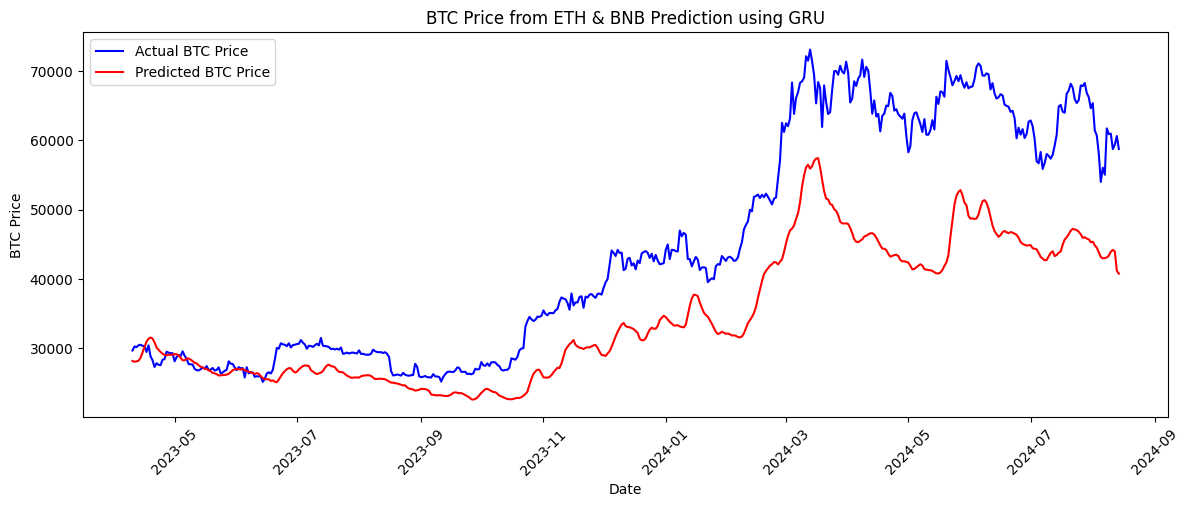

In [10]:
# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual, color='blue', label='Actual BTC Price')
plt.plot(test_dates, predicted, color='red', label='Predicted BTC Price')
plt.title('BTC Price from ETH & BNB Prediction using GRU')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.xticks(rotation=45)  
plt.legend()
plt.show()


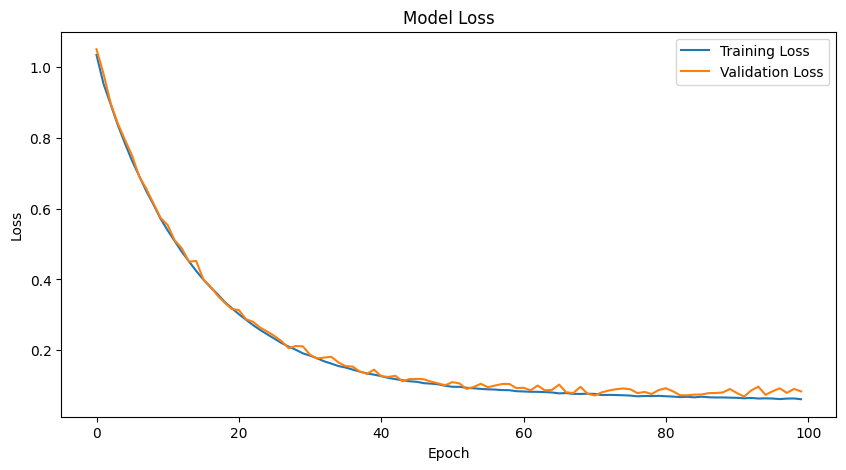

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# All features

# BNB from BTC

In [12]:
# Convert the Date column to datetime
for df in [btc_data, bnb_data]:
    df['Date'] = pd.to_datetime(df['Date'])

#Merging the datasets
merged_data =  btc_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
merged_data = merged_data.merge(
    bnb_data[['Date', 'Open', 'High', 'Low', 'Close','Volume']].rename(columns={
        'Open': 'BNB_Open', 'High': 'BNB_High', 'Low': 'BNB_Low', 'Close': 'BNB_Close', 'Volume': 'BNB_Volume'}), on='Date')


# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [13]:
merged_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BNB_Open,BNB_High,BNB_Low,BNB_Close,BNB_Volume
0,2017-11-09,7446.830078,7446.830078,7101.520020,7143.580078,3226249984,2.05314,2.17423,1.89394,1.99077,19192200
1,2017-11-10,7173.729980,7312.000000,6436.870117,6618.140137,5208249856,2.00773,2.06947,1.64478,1.79684,11155000
2,2017-11-11,6618.609863,6873.149902,6204.220215,6357.600098,4908680192,1.78628,1.91775,1.61429,1.67047,8178150
3,2017-11-12,6295.450195,6625.049805,5519.009766,5950.069824,8957349888,1.66889,1.67280,1.46256,1.51969,15298700
4,2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6263249920,1.52601,1.73502,1.51760,1.68662,12238800


In [14]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except BNB variables
        y = data[i+sequence_length, -2]  # Target is BNB_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7 
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [15]:
# Build the GRU model
model = Sequential()
model.add(GRU(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
50/50 [==============================] - 5s 24ms/step - loss: 0.9285 - val_loss: 1.0249
Epoch 2/100
50/50 [==============================] - 1s 10ms/step - loss: 0.8490 - val_loss: 0.9327
Epoch 3/100
50/50 [==============================] - 0s 10ms/step - loss: 0.7961 - val_loss: 0.8749
Epoch 4/100
50/50 [==============================] - 0s 10ms/step - loss: 0.7427 - val_loss: 0.8324
Epoch 5/100
50/50 [==============================] - 0s 10ms/step - loss: 0.6973 - val_loss: 0.7929
Epoch 6/100
50/50 [==============================] - 0s 9ms/step - loss: 0.6521 - val_loss: 0.7442
Epoch 7/100
50/50 [==============================] - 0s 10ms/step - loss: 0.6124 - val_loss: 0.7134
Epoch 8/100
50/50 [==============================] - 0s 10ms/step - loss: 0.5729 - val_loss: 0.6621
Epoch 9/100
50/50 [==============================] - 0s 10ms/step - loss: 0.5390 - val_loss: 0.6352
Epoch 10/100
50/50 [==============================] - 0s 10ms/step - loss: 0.5045 - val_loss: 0.6068


In [17]:
# Create a placeholder for inverse transformation
predicted_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the BNB_Close column)
predicted_full[:, -2] = predictions[:, 0]
actual_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted = scaler.inverse_transform(predicted_full)[:, -2]
actual = scaler.inverse_transform(actual_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

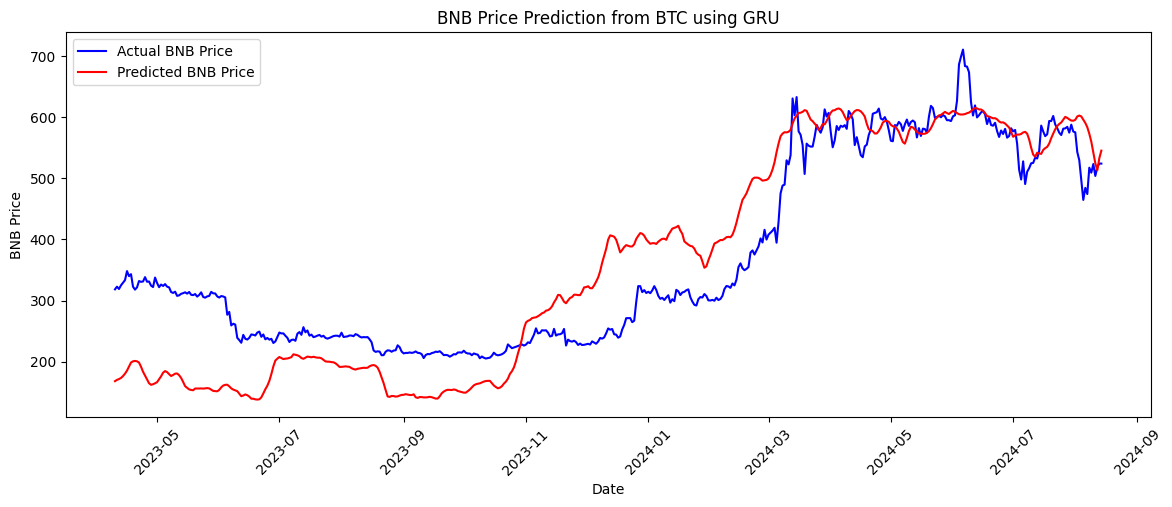

In [18]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual, color='blue', label='Actual BNB Price')
plt.plot(test_dates, predicted, color='red', label='Predicted BNB Price')
plt.title('BNB Price Prediction from BTC using GRU')
plt.xlabel('Date')
plt.ylabel('BNB Price')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()
plt.show()

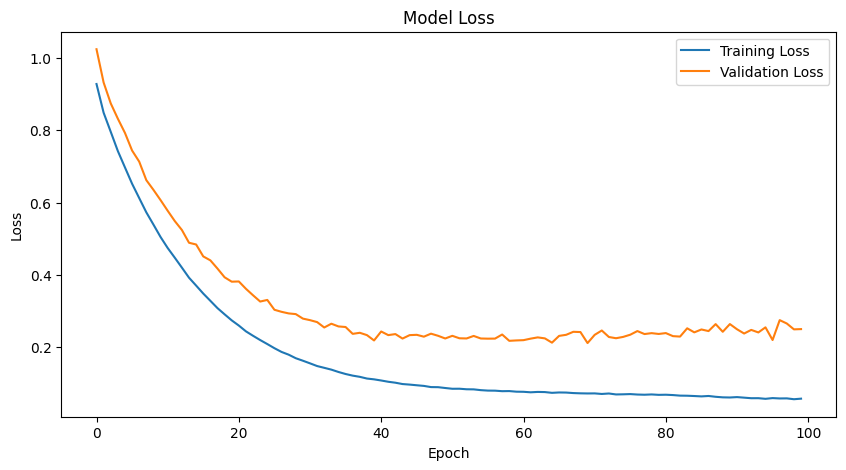

In [19]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## ETH from BTC

In [20]:
# Convert the Date column to datetime
for df in [btc_data, eth_data]:
    df['Date'] = pd.to_datetime(df['Date'])

#Merging the datasets
merged_data =  btc_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
merged_data = merged_data.merge(
    eth_data[['Date', 'Open', 'High', 'Low', 'Close','Volume']].rename(columns={
        'Open': 'ETH_Open', 'High': 'ETH_High', 'Low': 'ETH_Low', 'Close': 'ETH_Close', 'Volume': 'ETH_Volume'}), on='Date')


# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [21]:
merged_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume
0,2017-11-09,7446.830078,7446.830078,7101.520020,7143.580078,3226249984,308.644989,329.451996,307.056000,320.884003,893249984
1,2017-11-10,7173.729980,7312.000000,6436.870117,6618.140137,5208249856,320.670990,324.717987,294.541992,299.252991,885985984
2,2017-11-11,6618.609863,6873.149902,6204.220215,6357.600098,4908680192,298.585999,319.453003,298.191986,314.681000,842300992
3,2017-11-12,6295.450195,6625.049805,5519.009766,5950.069824,8957349888,314.690002,319.153015,298.513000,307.907990,1613479936
4,2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6263249920,307.024994,328.415009,307.024994,316.716003,1041889984


In [22]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except ETH variables
        y = data[i+sequence_length, -2]  # Target is ETH_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [23]:
# Build the GRU model
model = Sequential()
model.add(GRU(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [24]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
50/50 [==============================] - 4s 24ms/step - loss: 0.9805 - val_loss: 0.9717
Epoch 2/100
50/50 [==============================] - 0s 10ms/step - loss: 0.8660 - val_loss: 0.8652
Epoch 3/100
50/50 [==============================] - 0s 10ms/step - loss: 0.7970 - val_loss: 0.7893
Epoch 4/100
50/50 [==============================] - 0s 10ms/step - loss: 0.7461 - val_loss: 0.7401
Epoch 5/100
50/50 [==============================] - 0s 10ms/step - loss: 0.6962 - val_loss: 0.6799
Epoch 6/100
50/50 [==============================] - 0s 10ms/step - loss: 0.6533 - val_loss: 0.6473
Epoch 7/100
50/50 [==============================] - 0s 9ms/step - loss: 0.6138 - val_loss: 0.5919
Epoch 8/100
50/50 [==============================] - 0s 8ms/step - loss: 0.5774 - val_loss: 0.5773
Epoch 9/100
50/50 [==============================] - 0s 9ms/step - loss: 0.5388 - val_loss: 0.5275
Epoch 10/100
50/50 [==============================] - 0s 9ms/step - loss: 0.5079 - val_loss: 0.5221
Epo

In [25]:
# Create a placeholder for inverse transformation
# Since the scaler was fitted on all columns, we need to recreate this shape
predicted_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the ETH_Close column)
predicted_full[:, -2] = predictions[:, 0]
actual_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted = scaler.inverse_transform(predicted_full)[:, -2]
actual = scaler.inverse_transform(actual_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

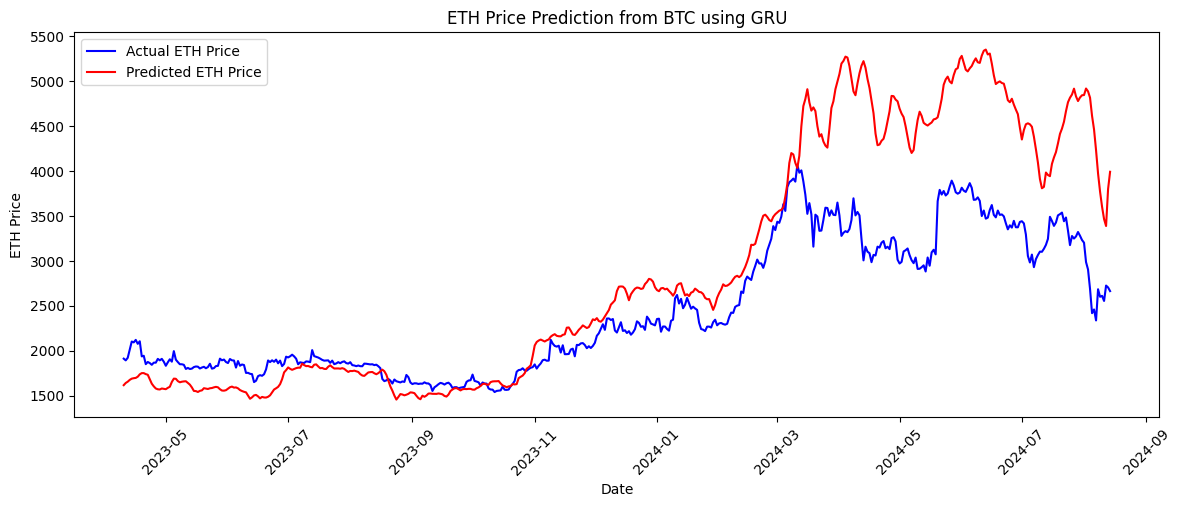

In [26]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual, color='blue', label='Actual ETH Price')
plt.plot(test_dates, predicted, color='red', label='Predicted ETH Price')
plt.title('ETH Price Prediction from BTC using GRU')
plt.xlabel('Date')
plt.ylabel('ETH Price')
plt.xticks(rotation=45)  
plt.legend()
plt.show()

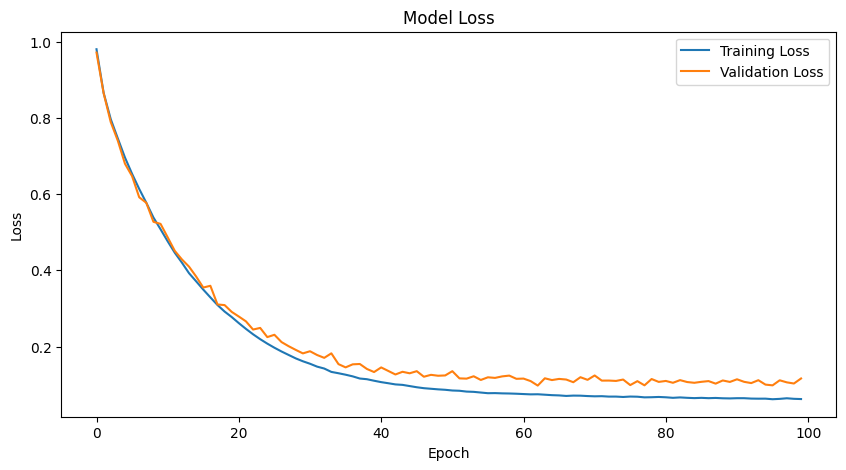

In [27]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()